In [1]:
import csv
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split

In [2]:
train_data = pd.read_csv("data/train_with_embeddings.csv")

In [3]:
# new features
train_data["url_count"] = train_data["urls"].apply(lambda s: s[1:-1].count("\'")/2)
train_data["text_len"] = train_data["text"].apply(lambda s: len(s))
train_data["hashtags_count"] = train_data["hashtags"].apply(lambda s: s[1:-1].count("\'")/2)
train_data["day"] = train_data["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t/1000).day)
train_data["hour"] = train_data["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t/1000).hour)

# text features
train_data["avg_word_len"] = train_data["text"].apply(lambda s: np.mean([len(w) for w in s.split()]))
train_data["rep_words_freq"] = train_data["text"].apply(lambda s: np.mean(len(list(set(s.split())))/len(s.split())))
train_data["rep_chars_freq"] = train_data["text"].apply(lambda s: np.mean(len(list(set(s)))/len(list(s))))
train_data["max_char_freq"] = train_data["text"].apply(lambda s: max( [s.count(c) for c in list(set(s))] )   /len(list(s)))
train_data["avg_word_count"] = train_data["text"].apply(lambda s: len(s.split()))

# indicators of keywords
train_data["Macron"] =  train_data["text"].apply(lambda s: ("macron" in s.lower().split()))
train_data["Zemmour"] =  train_data["text"].apply(lambda s: ("zemmour" in s.lower().split()))
train_data["Melenchon"] =  train_data["text"].apply(lambda s: ("melenchon" in s.replace("é","e").lower().split()))
train_data["rt"] =  train_data["text"].apply(lambda s: ("rt" in s.lower().split()))

In [4]:
display(train_data)

,Unnamed: 0,text,retweets_count,favorites_count,followers_count,statuses_count,friends_count,mentions,urls,verified,...,hour,avg_word_len,rep_words_freq,rep_chars_freq,max_char_freq,avg_word_count,Macron,Zemmour,Melenchon,rt
0,0,rt refarcir macron ans nom prépare,3,0,3682,453535,3628,[],[],0,...,5,4.833333,1.000000,0.411765,0.205882,6,True,False,False,True
1,1,populaire,0,0,86,1016,284,[],[],0,...,12,9.000000,1.000000,0.888889,0.222222,1,False,False,False,False
2,2,faut dégager cinglé,3,1,1944,28234,1995,[],[],0,...,18,5.666667,1.000000,0.736842,0.157895,3,False,False,False,False
3,3,enseignants mettre prescriptions président rép...,0,0,1,1072,0,[],['https://t.co/rytlted08g'],0,...,11,7.857143,0.928571,0.170732,0.138211,14,False,False,False,False
4,4,mafieuse oppressive macron,0,0,13957,25311,10841,[],[],0,...,11,8.000000,1.000000,0.538462,0.153846,3,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353964,353964,gonflette tour raciste frustré,0,0,34,1509,55,[],['https://t.co/pma33zhslx'],0,...,13,6.750000,1.000000,0.500000,0.166667,4,False,False,False,False
353965,353965,france caste crapuleuse encadrée gangsters irr...,0,0,89,11166,127,[],[],0,...,8,9.000000,1.000000,0.260870,0.159420,7,False,False,False,False
353966,353966,eric zemmour français berbère,3,0,1888,712,3086,[],[],0,...,12,6.500000,1.000000,0.551724,0.172414,4,False,True,False,False
353967,353967,gauchistes dépression pq,0,0,139,486,320,[],[],0,...,8,7.333333,1.000000,0.708333,0.166667,3,False,False,False,False


In [5]:
# select useful columns
train_data_filtered = train_data.drop(["text", "urls", "mentions", "hashtags", "timestamp", "TweetID"], axis=1)
# train_data_filtered = train_data.loc[:, ["retweets_count","favorites_count","followers_count","statuses_count","friends_count",
#                                  "hashtags_count","hour","verified","url_count","text_len","rt","Macron","Zemmour","Melenchon"]]


X_train, X_eval, y_train, y_eval = train_test_split(train_data_filtered.drop("retweets_count", axis=1),
                                                    train_data_filtered["retweets_count"],
                                                    random_state=42, test_size=0.1)

# Standardize the data
normal_columns = train_data_filtered.drop(["hour", "verified", "Macron", "Zemmour", "Melenchon", "url_count", "rt", "retweets_count"], axis=1).columns
mu, sigma = X_train[normal_columns].mean(axis=0), X_train[normal_columns].std(axis=0)
X_train.loc[:, normal_columns] = (X_train[normal_columns] - mu) / sigma
X_eval.loc[:, normal_columns] = (X_eval[normal_columns] - mu) / sigma

In [6]:
X_train.shape

(318572, 52)

In [7]:
X_train = np.array(X_train)[..., np.newaxis]
X_eval = np.array(X_eval)[..., np.newaxis]

In [8]:
X_train.shape

(318572, 52, 1)

In [9]:
from keras.models import Sequential
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout

2022-12-05 01:58:09.676714: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-05 01:58:09.780067: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-05 01:58:10.234317: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-05 01:58:10.234378: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not l

In [10]:
model = Sequential()
model.add(Conv1D(8, 3, activation='relu', padding='same',
                            input_shape=(X_train.shape[1], 1)))
model.add(Conv1D(8, 3, activation='relu', padding='same',
                            input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

2022-12-05 01:58:10.698221: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_SYSTEM_DRIVER_MISMATCH: system has unsupported display driver / cuda driver combination
2022-12-05 01:58:10.698251: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: danilo-Nitro-AN515-58
2022-12-05 01:58:10.698256: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: danilo-Nitro-AN515-58
2022-12-05 01:58:10.698395: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.108.3
2022-12-05 01:58:10.698412: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 525.60.11
2022-12-05 01:58:10.698416: E tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 525.60.11 does not match DSO version 510.108.3 -- cannot find working devices in this co

In [11]:
# import tensorflow_addons as tfa
# optimizer = tfa.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4)
# model.compile(optimizer=optimizer, loss='mae')

In [12]:
model.compile(optimizer="adam", loss='mae')

In [13]:
history = model.fit(X_train.astype(np.float32), y_train.astype(np.float32), epochs=200, batch_size=1024,
         validation_data=(X_eval.astype(np.float32), y_eval.astype(np.float32)), shuffle=True)

Epoch 1/200
312/312 [==============================] - 2s 5ms/step - loss: 15.3354 - val_loss: 13.5381
Epoch 2/200
312/312 [==============================] - 1s 5ms/step - loss: 8.6139 - val_loss: 7.4654
Epoch 3/200
312/312 [==============================] - 1s 5ms/step - loss: 7.5192 - val_loss: 7.2735
Epoch 4/200
312/312 [==============================] - 1s 5ms/step - loss: 7.3822 - val_loss: 7.2762
Epoch 5/200
312/312 [==============================] - 1s 5ms/step - loss: 7.3218 - val_loss: 7.3025
Epoch 6/200
312/312 [==============================] - 1s 5ms/step - loss: 7.2047 - val_loss: 7.0410
Epoch 7/200
312/312 [==============================] - 1s 5ms/step - loss: 7.1306 - val_loss: 7.6917
Epoch 8/200
312/312 [==============================] - 1s 4ms/step - loss: 7.0646 - val_loss: 6.8304
Epoch 9/200
312/312 [==============================] - 1s 5ms/step - loss: 6.9790 - val_loss: 6.7742
Epoch 10/200
312/312 [==============================] - 1s 5ms/step - loss: 6.9232 - val_

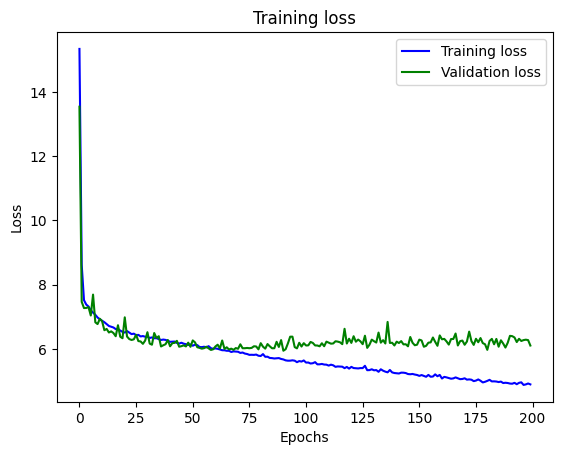

In [14]:
plt.plot(history.epoch, history.history["loss"], 'b', label='Training loss')
plt.plot(history.epoch, history.history["val_loss"], 'g', label='Validation loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
model.evaluate(X_eval.values.astype(np.float32),  y_eval.values.astype(np.float32), verbose=2)

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [ ]:
pred = model.predict(X_train.values.astype(np.float32))
print(pred)

In [ ]:
# plt.scatter(X_train["favorites_count"], model.predict(X_train))
# plt.scatter(X_train["favorites_count"], y_train.values.astype(np.float32))

In [ ]:
# evaluation

eval_data = pd.read_csv("data/evaluation_with_embeddings.csv")
tweets = eval_data["TweetID"]

In [ ]:
eval_data["url_count"] = eval_data["urls"].apply(lambda s: s[1:-1].count("\'")/2)
eval_data["text_len"] = eval_data["text"].apply(lambda s: len(s))
eval_data["hashtags_count"] = eval_data["hashtags"].apply(lambda s: s[1:-1].count("\'")/2)
eval_data["day"] = eval_data["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t/1000).day)
eval_data["hour"] = eval_data["timestamp"].apply(lambda t: datetime.utcfromtimestamp(t/1000).hour)
eval_data["Macron"] =  eval_data["text"].apply(lambda s: ("macron" in s.lower().split()))
eval_data["Zemmour"] =  eval_data["text"].apply(lambda s: ("zemmour" in s.lower().split()))
eval_data["Melenchon"] =  eval_data["text"].apply(lambda s: ("melenchon" in s.lower().split()))
eval_data["rt"] =  eval_data["text"].apply(lambda s: ("rt" in s.lower().split()))

# print("sentiment analysis...")
# eval_data["compound"] =  eval_data["text"].apply(lambda s: sia.polarity_scores(s)['compound'])

eval_data = eval_data.drop(["text", "urls", "mentions", "hashtags", "timestamp", "TweetID"], axis=1)

# normalize
eval_data.loc[:, normal_columns] = (eval_data.loc[:, normal_columns] - mu) / sigma

print(eval_data)

pred = model.predict(eval_data.values.astype(np.float32))

print(pred)

# output normalization
for i,p in enumerate(pred):
    if p<0: pred[i] = 0

In [ ]:
with open("data/predictions.csv", 'w') as f:
    writer = csv.writer(f)
    writer.writerow(["TweetID", "retweets_count"])
    for index, prediction in enumerate(pred):
        writer.writerow([str(tweets[index]) , str(int(prediction))])